In [1]:
from jax.config import config
config.update("jax_enable_x64", True)

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl

from hyperion.models.photon_arrival_time.pdf import make_exp_exp_exp, make_obj_func, sample_exp_exp_exp, fb5_mle
from hyperion.models.photon_arrival_time.net import PhotonArivalTimePars
import pickle
import scipy.optimize
from torch.utils.data import DataLoader
from hyperion.utils import cherenkov_ang_dist, ANG_DIST_INT
from tqdm.notebook import trange, tqdm
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.tensorboard import SummaryWriter

import torch.optim as optim
%matplotlib inline


from jax import numpy as jnp
from jax import value_and_grad, jit
import pandas as pd
from glob import glob

2021-10-28 10:52:19.478072: E external/org_tensorflow/tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error


Text(0, 0.5, 'PDF')

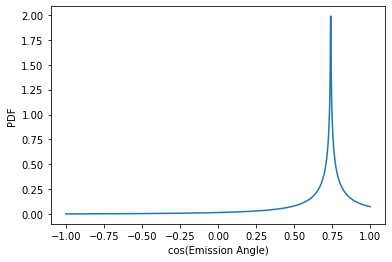

In [2]:
ct = jnp.linspace(-1, 1, 1000)
plt.plot(ct, cherenkov_ang_dist(ct))
plt.xlabel("cos(Emission Angle)")
plt.ylabel("PDF")

In [3]:
def make_data(t, w, det_dist, thr=2):
    tgeo = t -((det_dist-r) / c_medium)
    mask = (tgeo  > thr)
    
    return tgeo[mask]-thr, w[mask], 1 - (w[mask].sum() / w.sum())

def fit(obj):
    best_res = None
    for _ in range(5):
       
        """
        seed = np.random.uniform(0, 1, size=3)
        res = scipy.optimize.fmin_l_bfgs_b(obj, seed, 
                                            bounds=((1E-3, None), (1E-3, None),  (1E-6, 1-1E-6)),
                                            factr=100,
                                            approx_grad=False)
                            
        """
        
        seed = np.random.uniform(0, 1, size=5)
        seed[3] *= np.pi / 2
        seed[4] *= np.pi / 2
        res = scipy.optimize.fmin_l_bfgs_b(obj, seed, 
                                            bounds=((1E-3, None), (1E-3, None), (1E-3, None),
                                                    (0, np.pi/2), (0, np.pi/2)),
                                            factr=100,
                                            approx_grad=False)
        
        
        if res[2]["warnflag"] == 2:
            continue
        if (best_res is None) or res[1] < best_res[1]:
            best_res = res
    return best_res

def wrap(f):
    def _f(*pars):
        if len(pars) == 1:
            pars = pars[0]
        res = f(*pars)
        return np.array(res[0], order="F"), np.array(res[1], order="F")
    return _f

In [4]:
sca_len = 100
c_medium = 0.3 / 1.35
abs_len = 30
r = 0.21
det_ph = pickle.load(open("photon_table_1.pickle", "rb"))
#fit_pars = pickle.load(open("photon_fitpars_1.pickle", "rb"))

In [7]:
det_dist, isec_times, ph_thetas, stepss, isec_poss = det_ph[0]

In [9]:
det_center = np.asarray([0, 0, det_dist])
rel = (isec_poss - det_center)
rel = rel / np.linalg.norm(rel, axis=1)[:, np.newaxis]




In [81]:

def fb8_mle(xs, weights,  warning='warn'):
    """
    Generates a FB8Distribution fitted to xs using maximum likelihood estimation
    For a first approximation kent_me() is used. The function
    -k.log_likelihood(xs)/len(xs) (where k is an instance of FB8Distribution) is
    minimized. If fb5_only=False, sequentially fit a Kent, FB6 and then FB8
    distribution. Gradients are used for the FB6 and FB8 fits.
    Input:
      - xs: values on the sphere to be fitted by MLE, ordering is (z, x, y)
      - verbose: if True, output is given for every step
      - return_intermediate_values: if true the values of all intermediate steps
        are returned as well
      - warning: choices are
        - "warn": issues any warning via warning.warn
        - a file object: which results in any warning message being written to a file
          (e.g. stdout)
        - "none": or any other value for this argument results in no warnings to be issued
      - fb5_only: perform fit to Kent distribution only
    Output:
      - an instance of the fitted FB8Distribution
    Extra output:
      - if return_intermediate_values is specified then
      a tuple is returned with the FB8Distribution argument as the first element
      and containing the extra requested values in the rest of the elements.
    """
    lenxs = len(xs)
    # method that generates the minus L to be minimized
    # x = theta phi psi kappa beta eta alpha rho
    def minus_log_likelihood(x):
        if np.any(np.isnan(x)):
            return np.inf
        if x[3] < 0 or x[4] < 0:
            return np.inf
        ### DEBUG ###
        # if len(x) > 5 and (x[5] > 1 or x[5] < -1):
        #     return np.inf
        return -(fb8(*x).log_pdf(xs)*weights).sum()/weights.sum()

    
    # first get estimated moments
    k_me = kent_me(xs)
    theta, phi, psi, kappa, beta = k_me.theta, k_me.phi, k_me.psi, k_me.kappa, k_me.beta

    # here the mle is done
    x_start = np.array([theta, phi, psi, kappa, beta])
    y_start = np.array([theta, phi, psi, beta, kappa, -0.99])

    # First try a FB5 fit
    # constrain kappa, beta >= 0 and 2*beta <= kappa for FB5 (Kent 1982)

    cons = ({"type": "ineq",
             "fun": lambda x: x[3] - 2 * x[4]},
            {"type": "ineq",
             "fun": lambda x: x[3]},
            {"type": "ineq",
             "fun": lambda x: x[4]})
    all_values = scipy.optimize.minimize(minus_log_likelihood,
                          x_start,
                          method="SLSQP",
                          constraints=cons,
                          options={"disp": False, "ftol": 1e-08,
                                   "maxiter": 100})
    return fb8(*all_values.x)

In [15]:
from matplotlib import cm
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
from sphere.distribution import fb8

def grid(npts):
    return [_.flatten() for _ in np.meshgrid(np.linspace(0, np.pi, npts), np.linspace(0,2*np.pi, npts))]

class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)


def plot_fb8(fb8, npts, offset, ax):
    """
    Plot fb8 on 3D sphere
    """
    xs = fb8.spherical_coordinates_to_nu(*grid(npts))
    pdfs = fb8.pdf(xs)
    z,x,y = xs.T #!!! Note the ordering for xs here is used consistently throughout. Follows Kent's 1982 paper.
    z += offset[2]
    x += offset[0]
    y += offset[1]

    ax.plot_surface(x.reshape(npts, npts),
                    y.reshape(npts, npts),
                    z.reshape(npts, npts),
                    alpha=0.5,
                    rstride=1, cstride=1,
                    facecolors=cm.plasma(pdfs.reshape(npts, npts)/pdfs.max()))
    #ax.set_axis_off()
    return ax



In [133]:
def sph_to_cart(theta, phi=0, r=1):
    """Transform spherical to cartesian coordinates."""
    x = r * np.sin(theta) * np.cos(phi)
    y = r * np.sin(theta) * np.sin(phi)
    z = r * np.cos(theta)

    return np.array([x, y, z])

[1.99133066 1.15026199] [5.17603659 5.17603659]


(0.0, 20.0)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:16: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  app.launch_new_instance()


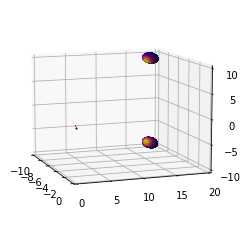

In [29]:
inp_data = rel.copy()
inp_data[:,[2, 0]] = inp_data[:,[0, 2]]
weights = np.exp(-isec_times *c_medium / abs_len)

module_coords = np.asarray([[-10., 20, 10], [-10, 20., -10]])
module_coords /= np.linalg.norm(module_coords, axis=1)[:, np.newaxis]
module_coords *= det_dist

pdir = np.asarray([0, 0, 1])

vtheta = np.arccos(np.dot(module_coords[0], pdir)/ np.linalg.norm(module_coords[0]))
vtheta2 = np.arccos(np.dot(module_coords[1], pdir)/ np.linalg.norm(module_coords[1]))

c_weight = cherenkov_ang_dist(np.cos(ph_thetas-vtheta)) / ANG_DIST_INT *2
dist = fb5_mle(inp_data[:10000], (weights*c_weight)[:10000])

c_weight = cherenkov_ang_dist(np.cos(ph_thetas-vtheta2)) / ANG_DIST_INT *2
dist2 = fb5_mle(inp_data[:10000], (weights*c_weight)[:10000])


rel_theta = np.arccos(module_coords[:, 2] / det_dist) 
rel_phi = np.arccos(module_coords[:, 0] / det_dist / np.sin(rel_theta))

rel_theta = np.pi - rel_theta
rel_phi =  np.pi + rel_phi

print(rel_theta, rel_phi)

    
fig = plt.figure(figsize=plt.figaspect(1.))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=10., azim=-20)


dtest = fb8(rel_theta[0], rel_phi[0], 0, dist[3], dist[4], 1.00, 0.00, 0.00)
ax = plot_fb8(dtest, 200, module_coords[0], ax)

dtest = fb8(rel_theta[1], rel_phi[1], 0, dist[3], dist[4], 1.00, 0.00, 0.00)
ax = plot_fb8(dtest, 200, module_coords[1], ax)





ax.plot(0, 0, 0, marker="o", ms=1, color="k", zorder=100)
a = Arrow3D([0, pdir[0]], [0, pdir[1]], 
            [0, pdir[2]], mutation_scale=1, 
            lw=1, arrowstyle="-|>", color="r")
ax.add_artist(a)

ax.set_xlim(-10, 0)
ax.set_ylim(0, 20)
#ax.plot(*sph_to_cart(theta_target, phi_target), marker="o", ms=5, color="k", zorder=100)

#ax.plot(*sph_to_cart(theta_target, phi_target), marker="o", ms=5, color="k", zorder=100)

In [158]:
plot_fb8(dist, 200)
plot_fb8(dist2, 200)

TypeError: plot_fb8() missing 1 required positional argument: 'offset'

In [85]:
dist

fb8(3.06, -2.70, 0.66, 2.74, 0.00, 1.00, 0.00, 0.00)

In [86]:
dist2

fb8(3.13, 2.30, 0.80, 2.80, 0.04, 1.00, 0.00, 0.00)

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"


(0.0, 10.0)

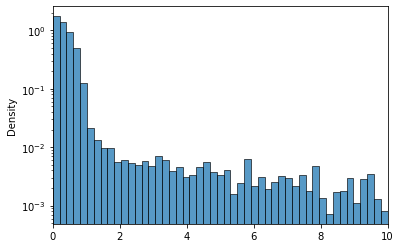

In [8]:
pdf = make_exp_exp_exp(sampler=False)
det_dist, isec_times, ph_thetas, stepss, isec_poss = det_ph[0]
weights = np.exp(-isec_times *c_medium / abs_len)
c_weight = cherenkov_ang_dist(np.cos(ph_thetas-0)) / ANG_DIST_INT *2
t, w, ucf = make_data(isec_times, weights*c_weight, det_dist, thr=2)
obj = make_obj_func(pdf, t, w, 6)
t, w, _ = make_data(isec_times, weights*c_weight, det_dist, thr=0)
sns.histplot(x=t, weights=w, bins=np.linspace(0, 10, 50), stat="density")
plt.semilogy()


xs = np.linspace(0, 500, 500)
#plt.plot(xs, (1-ucf)*np.exp(func(xs, 0.5, 0.1, 0.01, 0.2, 0.2, 0.5)))
#plt.ylim(1E-10, 1)
plt.xlim(0, 10)

In [98]:
obj, func = make_exp_exp_exp(t, w)
func(t, 0.65954089, 0.00862261, 0.08710051, 1.2769194, 3.14159265)

[ 1.03983779e-09  3.43589164e-09 -1.00000000e+00]


DeviceArray([nan, nan, nan, ..., nan, nan, nan], dtype=float64)

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:376: Fut

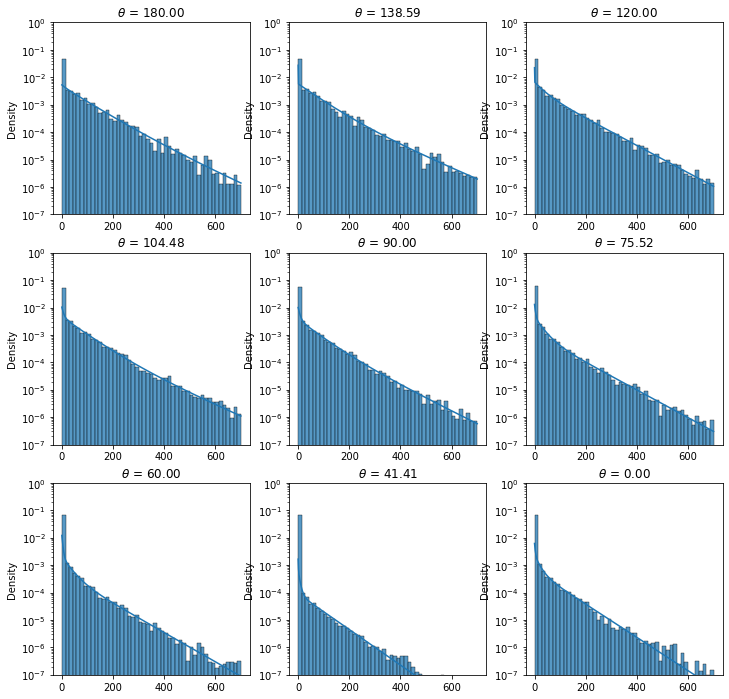

In [10]:
fig, axs = plt.subplots(3, 3, figsize=(12, 12))

fit_results = []


thetas = np.arccos(np.linspace(-1, 1, 9))
pdf = make_exp_exp_exp(sampler=False)

for theta, ax in zip(thetas, axs.ravel()):
    
    det_dist, isec_times, ph_thetas, stepss, isec_poss = det_ph[0]
    weights = np.exp(-isec_times *c_medium / abs_len)
    c_weight = cherenkov_ang_dist(np.cos(ph_thetas-theta)) / ANG_DIST_INT *2
    t, w, ucf = make_data(isec_times, weights*c_weight, det_dist, thr=2)
    obj = make_obj_func(pdf, t, w, 5)
    pars = fit(wrap(obj))
    t, w, _ = make_data(isec_times, weights*c_weight, det_dist, thr=0)
    sns.histplot(x=t, weights=w, bins=np.linspace(0, 700, 50), stat="density", ax=ax)
    plt.semilogy()

    
    xs = np.linspace(0, 700, 500)
    ax.plot(xs, (1-ucf)*np.exp(pdf(xs, *pars[0])))
    #plt.plot(xs, np.exp(lhfunc(xs, [1.5, 1, 1, 0.5])))
    #plt.semilogy()
    ax.set_ylim(1E-7, 1)
    ax.set_yscale("log")
    ax.set_title(rf"$\theta$ = {np.degrees(theta):.2f}")




In [257]:
det_dist

22.360679774997894

In [312]:
fit_pars = pickle.load(open("photon_fitpars_0.pickle", "rb"))
det_ph = pickle.load(open("photon_table_0.pickle", "rb"))

In [113]:
fit_pars[0]

{'input': [1.4730135689716053, 22.360679774997894],
 'output': [0.8168037376055904,
  0.05203713478461943,
  0.2842984959474887,
  0.14494814298017744,
  0.45148745083161806,
  0.7588761551793741,
  0.735687255859375,
  3.693173502604167e-06]}

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:376: Fut

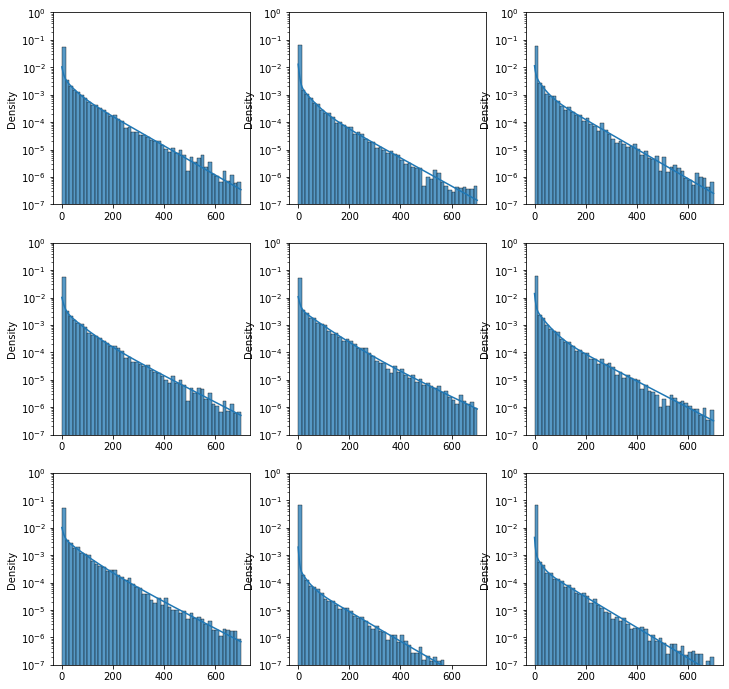

In [115]:
fig, axs = plt.subplots(3, 3, figsize=(12, 12))

fit_results = []


for i, ax, fp in zip(range(9), axs.ravel(), fit_pars):
    det_dist, isec_times, ph_thetas, stepss, isec_poss = det_ph[0]
    weights = jnp.exp(-isec_times *c_medium / abs_len)
    c_weight = cherenkov_ang_dist(np.cos(ph_thetas-fp["input"][0])) / ANG_DIST_INT *2
    t, w, ucf = make_data(isec_times, weights*c_weight, det_dist, thr=2)
    _, func = make_exp_exp_exp(t, w)
    
    t, w, _ = make_data(isec_times, weights*c_weight, det_dist, thr=0)
    sns.histplot(x=t, weights=w, bins=np.linspace(0, 700, 50), stat="density", ax=ax)
    plt.semilogy()

    
    xs = np.linspace(0, 700, 500)
    ax.plot(xs, (1-ucf)*np.exp(func(xs, *fp["output"][:-2])))
    #plt.plot(xs, np.exp(lhfunc(xs, [1.5, 1, 1, 0.5])))
    #plt.semilogy()
    ax.set_ylim(1E-7, 1)
    ax.set_yscale("log")





In [2]:
class MeanStdScaler:
    def __init__(self, data, dont_shift=None, dont_scale=None):
        self._means = np.mean(data, axis=0)
        self._stds = np.std(data, axis=0)
        
        if dont_shift is not None:
            self._means[dont_shift] = 0
            
        if dont_scale is not None:
            self._stds[dont_scale] = 1
        
        
    def scale(self, data):
        return (data - self._means) / self._stds
    
    def unscale(self, data):
        return data * self._stds + self._means

In [4]:
fit_results = pickle.load(open("combined_photon_fitpars.pickle", "rb"))
data = []
for d in fit_results:
    data.append(list(d["input"]) + list(d["output"]))
data = np.asarray(np.vstack(data).squeeze(), dtype=np.float32)
data[:, [2, 3, 4]] = np.sort(data[:, [2, 3, 4]], axis=1)
data[:, 1] = np.log10(data[:, 1])
data[:, -1] = np.log10(data[:, -1]*300*1E7)
data[:, -2] = -np.log10(1-data[:, -2])
df = pd.DataFrame(data, columns=["theta", "r", "scale1", "scale2", "scale3", "w1", "w2", "usf", "surv_frac"])

#input_scaler = MeanStdScaler(data[:, :2])
#output_scaler = MeanStdScaler(data[:, 2:], dont_shift=[0, 1, 2, 3, 4, )
#data[:, :2] = input_scaler.scale(data[:, :2])
#data[:, 2:] = output_scaler.scale(data[:, 2:])

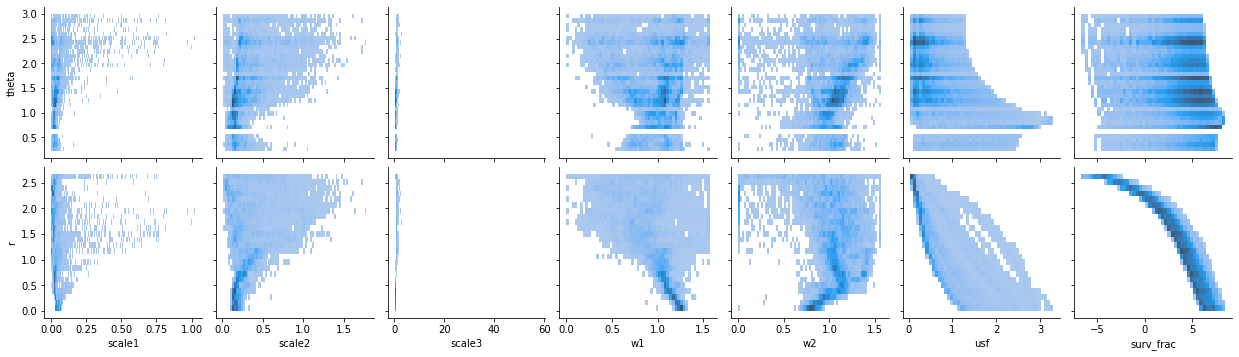

In [5]:
import pandas as pd
sns.pairplot(df,
             kind="hist", y_vars=["theta", "r"], x_vars = ["scale1", "scale2", "scale3", "w1", "w2", "usf", "surv_frac"])

In [6]:
rstate = np.random.RandomState(0)
indices = np.arange(len(data))
rstate.shuffle(indices)
data_shuff = data[indices]

split = int(0.5*len(data))
print(split)

g = torch.Generator()
torch.random.manual_seed(31337)
g.manual_seed(31337)

train_data = torch.tensor(data_shuff[:split])
test_data = torch.tensor(data_shuff[split:])


6592


In [5]:
def make_funnel(max_neurons, layer_count):
    layers = []
    out_feat = 7
    previous = max_neurons
    layers.append(max_neurons)
    step_size = int((previous - out_feat) / (layer_count))
    step_size = max(0, step_size)
    for _ in range(layer_count-1):
        previous = previous - step_size
        layers.append(previous)
    return layers
def train_net(conf, train_data, test_data, writer=None):
    train_loader = DataLoader(
        train_data,
        batch_size=conf["batch_size"],
        shuffle=True,
        #worker_init_fn=seed_worker,
        generator=g,
    )
    test_loader = DataLoader(
        test_data,
        batch_size=conf["batch_size"],
        shuffle=False,
        #worker_init_fn=seed_worker,
        generator=g,
    )
    
    layers = make_funnel(conf["max_neurons"], conf["layer_count"])
    net = PhotonArivalTimePars(
        layers, 2, 7, dropout=conf["dropout"],
        final_activations=[F.softplus]*6 + [nn.Identity()])
    optimizer = optim.Adam(net.parameters(), lr=conf["lr"])
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, conf["epochs"])


    def criterion(pred, target):
        #print(pred.shape, target.shape)
        mse = torch.mean((pred - target)**2, axis=0)
        return mse

    for epoch in range(conf["epochs"]):
        total_train_loss = 0
        for train in train_loader:
            net.train()
            optimizer.zero_grad()
            inp = train[:, :2]
            out = train[:, 2:]
            pred = net(inp)

            loss = criterion(pred, out)
            loss = loss.sum()
            loss.backward()

            total_train_loss += loss.item() * train.shape[0]

            optimizer.step()

        total_train_loss /= train_data.shape[0]

        total_test_loss = 0
        for test in test_loader:
            net.eval()

            inp = test[:, :2]
            out = test[:, 2:]
            pred = net(inp)

            loss = criterion(pred, out)
            loss = loss.sum()


            total_test_loss += loss.item() * test.shape[0]

        total_test_loss /= test_data.shape[0]

        if writer is not None:
            writer.add_scalar("Loss/train", total_train_loss, epoch)
            writer.add_scalar("Loss/test", total_test_loss, epoch)
            writer.add_scalar("LR", optimizer.param_groups[0]["lr"], epoch)

        scheduler.step()

    net.eval()
    inp = test_data[:, :2]
    out = test_data[:, 2:]
    pred = net(inp)
    loss = criterion(pred, out)
    loss = loss.sum()

    hparam_dict = dict(conf)
   

    if writer is not None:
        writer.add_hparams(hparam_dict, {"hparam/accuracy": loss})
        writer.flush()
        writer.close()
    
    return net
        

In [46]:
max_neurons = 700
layer_count = 3
layers = make_funnel(max_neurons, layer_count)
conf = {
        "epochs": 1000,
        "batch_size": 500,
        "lr": 0.01,
        "dropout": 0.5,
        "max_neurons": max_neurons,
        "layer_count": layer_count,
    }
writer = SummaryWriter(f"/tmp/tensorboard/runs/{conf['layer_count']}_{conf['max_neurons']}_{conf['batch_size']}_{conf['lr']}_{conf['epochs']}")
net = train_net(conf, train_data, test_data, writer)


In [28]:
!rm -rf /tmp/tensorboard/runs/*

In [32]:
for max_neurons in [700, 1500, 1700]:
    for layer_count in [2, 3, 4, 5]:
        for epochs in [700, 1000]:
            for lr in [0.05, 0.01]:

                conf = {
                    "epochs": epochs,
                    "batch_size": 500,
                    "lr": lr,
                    "dropout": 0.5,
                    "max_neurons": max_neurons,
                    "layer_count": layer_count,
                }

                writer = SummaryWriter(f"/tmp/tensorboard/runs/{conf['layer_count']}_{conf['max_neurons']}_{conf['batch_size']}_{conf['lr']}_{conf['epochs']}")

                net = train_net(conf, train_data, test_data, writer)




KeyboardInterrupt: 

In [47]:
torch.save(net, "data/arival_time_pars_net.dat")

In [11]:
net = torch.load("data/arival_time_pars_net.dat")


NameError: name 'test_data' is not defined

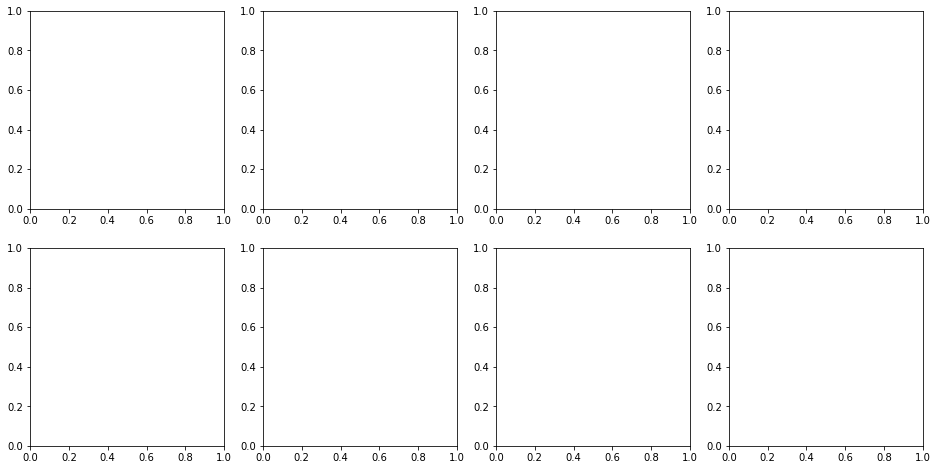

In [9]:
fig, axs = plt.subplots(2, 4, figsize=(16, 8))
for i, ax in zip(range(7), axs.ravel()):
    ax.scatter(test_data[:, 0], net(test_data[:, :2]).detach()[:, i]-test_data[:, 2+i].detach(), c=test_data[:, 1])
    ax.set_ylim(-4, 4)


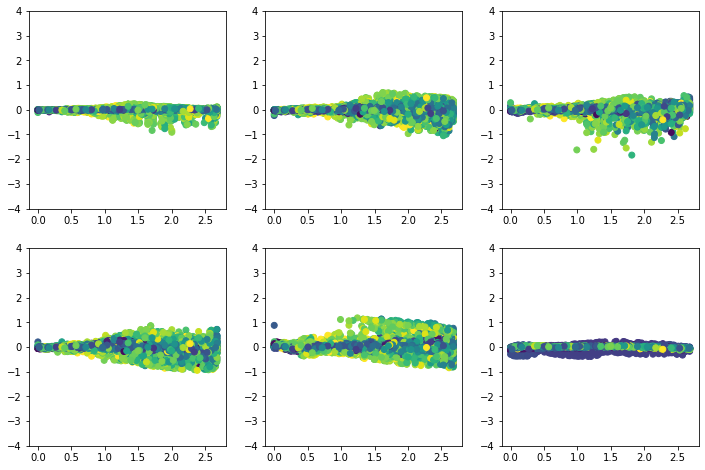

In [49]:
fig, axs = plt.subplots(2, 3, figsize=(12, 8))
for i, ax in enumerate(axs.ravel()):
    ax.scatter(train_data[:, 1], net(train_data[:, :2]).detach()[:, i]-train_data[:, 2+i].detach(), c=train_data[:, 0])
    ax.set_ylim(-4, 4)


In [50]:
tables = glob("/app/data/photon-tables/photon_table_*.pickle")
ph_tables = [pickle.load(open(tab, "rb")) for tab in tables]

for ph_table in ph_tables:
    det_dist, isec_times, ph_thetas, stepss, isec_poss = ph_table[0]
    weights = np.exp(-isec_times *c_medium / abs_len)

    thetas = np.arccos(np.linspace(-1, 1, 20))
    scaled_inp = torch.tensor([thetas, np.ones_like(thetas)*np.log10(det_dist)], dtype=torch.float32).T
    pars = np.asarray(net(scaled_inp).detach())

    llh_sum = 0

    for i, theta in enumerate(thetas):
        c_weight = cherenkov_ang_dist(np.cos(ph_thetas-theta)) / ANG_DIST_INT *2
        t, w, ucf = make_data(isec_times, weights*c_weight, det_dist, thr=2)
        _, func = make_exp_exp_exp(None, None)

        nph_pred = 10**(-15*pars[i, -1]) * 300 * 1E7
        nph_data = (c_weight * weights).sum()

        llh_poisson = nph_data * np.log(nph_pred) - nph_pred
        llh_sum += llh_poisson

    print(llh_sum)




"""
dx = np.diff(tbins)[0]
xs = np.linspace(1E-4, 700, 500)
ax.plot(xs, dx * 10**(-15*pars[-1] - pars[-2])*300*1E7*np.exp(func(xs, *pars[:-2])))
"""

-358501702.0838132


KeyboardInterrupt: 

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:376: Fut

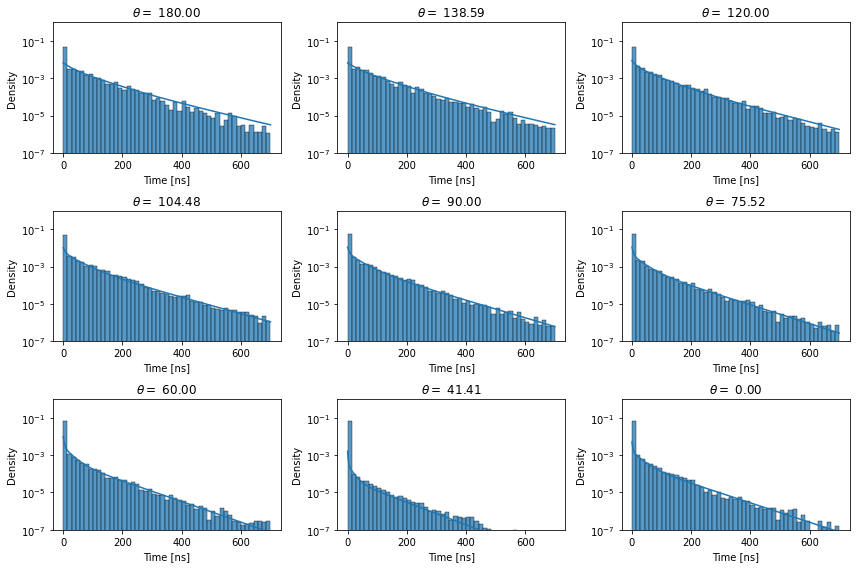

In [51]:
fig, axs = plt.subplots(3, 3, figsize=(12, 8))

thetas = np.arccos(np.linspace(-1, 1, 9))

for theta, ax in zip(thetas, axs.ravel()):
    
    det_dist, isec_times, ph_thetas, stepss, isec_poss = det_ph[0]
    weights = np.exp(-isec_times *c_medium / abs_len)
    c_weight = cherenkov_ang_dist(np.cos(ph_thetas-theta)) / ANG_DIST_INT *2
    t, w, usf = make_data(isec_times, weights*c_weight, det_dist, thr=2)
    obj, func = make_exp_exp_exp(t, w)
    
    scaled_inp = [[theta, np.log10(det_dist)]]
    pars = net(torch.tensor(scaled_inp, dtype=torch.float32))[0].detach()
    pars = np.asarray(pars)
    t, w, _ = make_data(isec_times, weights*c_weight, det_dist, thr=0)
    sns.histplot(x=t, weights=w, bins=np.linspace(0, 700, 50), stat="density", ax=ax)
    plt.semilogy()

    
    xs = np.linspace(1E-4, 700, 500)
    ax.plot(xs, 10**(-pars[-2])*np.exp(func(xs, *pars[:-2])))

    ax.set_ylim(1E-7, 1)
    ax.set_yscale("log")
    ax.set_title(fr"$\theta =$ {np.degrees(theta):.2f}")
    ax.set_xlabel("Time [ns]")

                 
plt.tight_layout()




/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:376: Fut

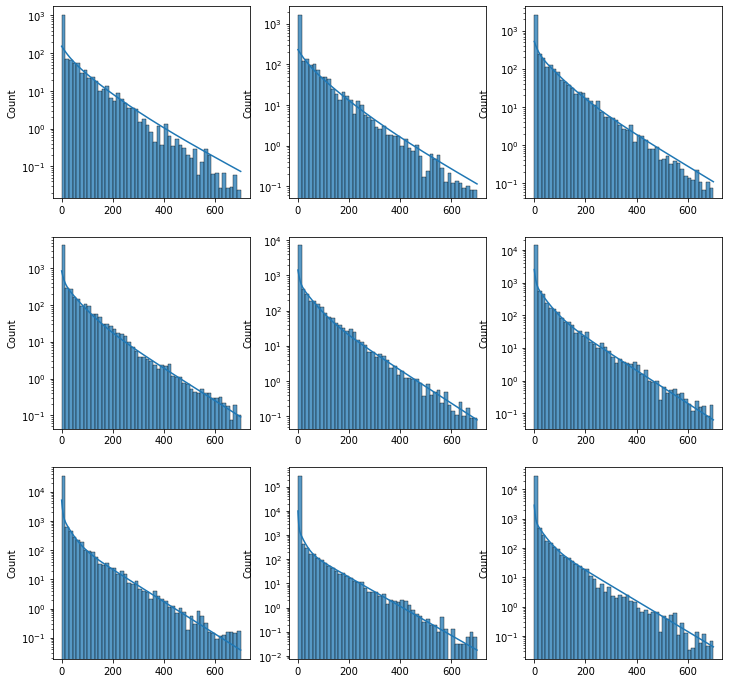

In [52]:
fig, axs = plt.subplots(3, 3, figsize=(12, 12))

thetas = np.arccos(np.linspace(-1, 1, 9))

tbins = np.linspace(0, 700, 50)
net.eval()
for theta, ax in zip(thetas, axs.ravel()):
    det_dist, isec_times, ph_thetas, stepss, isec_poss = det_ph[0]
    weights = np.exp(-isec_times *c_medium / abs_len)
    c_weight = cherenkov_ang_dist(np.cos(ph_thetas-theta)) / ANG_DIST_INT *2
    t, w, usf = make_data(isec_times, weights*c_weight, det_dist, thr=0)
    obj, func = make_exp_exp_exp(t, w)
    
    scaled_inp = [[theta, np.log10(det_dist)]]
    pars = net(torch.tensor(scaled_inp, dtype=torch.float32))[0].detach()
    pars = np.asarray(pars)
    sns.histplot(x=t, weights=w, bins=tbins, stat="count", ax=ax)
    plt.semilogy()

    dx = np.diff(tbins)[0]
    xs = np.linspace(1E-4, 700, 500)
    ax.plot(xs, dx * 10**(pars[-1] - pars[-2])*np.exp(func(xs, *pars[:-2])))

    #ax.set_ylim(1E-3, 1E4)
    ax.set_yscale("log")

                 





In [92]:
def to_three_par(w1, w2):
        three = (
            jnp.array(
                [jnp.sin(w1) * jnp.cos(w2), jnp.sin(w1) * jnp.sin(w2), jnp.cos(w1)]
            )
            ** 2
        )
        return three
    

def sample_timeres(pars, rstate):
    
    usf = 1-10**(-pars[5])
    n_ph_tot = int(10**pars[6])

    """
    n_ph_tot = np.random.poisson(
        surv_rate * sources[isource].amp * module_efficiencies[idom]
    )
    """
    n_direct, n_indirect = np.random.multinomial(
        n_ph_tot, [usf, 1 - usf]
    )
    

    
    all_samples = np.empty(n_ph_tot)

    expon_samples = sample(*pars[:-2], size=n_indirect, rstate=rstate) + 2

    uni_samples = rstate.uniform(0, 2, size=n_direct)
    
    all_samples[:n_direct] = uni_samples
    all_samples[n_direct:] = expon_samples
    return all_samples
    
    


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:376: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  and estimate_kws["bins"] == "auto"
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:376: Fut

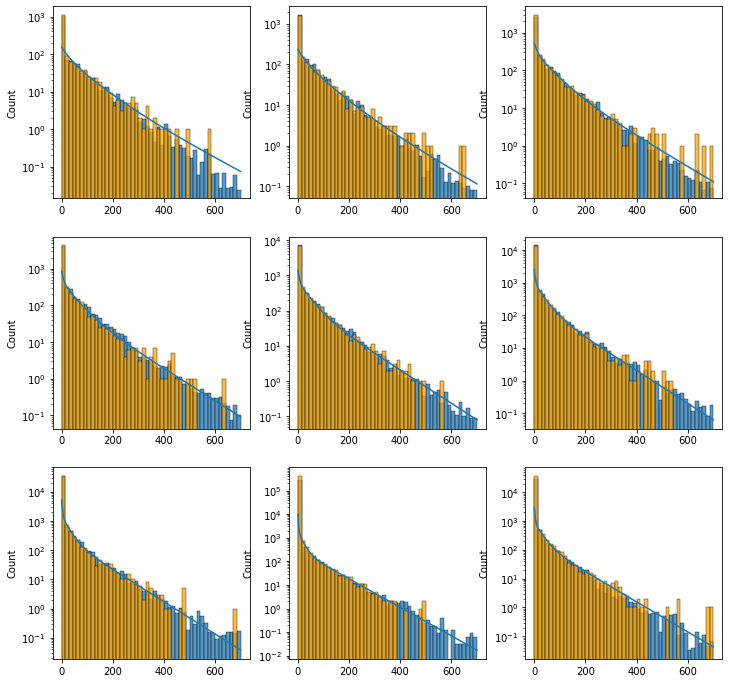

In [93]:
fig, axs = plt.subplots(3, 3, figsize=(12, 12))

thetas = np.arccos(np.linspace(-1, 1, 9))

tbins = np.linspace(0, 700, 50)
net.eval()
rstate = np.random.RandomState(0)

for theta, ax in zip(thetas, axs.ravel()):
    det_dist, isec_times, ph_thetas, stepss, isec_poss = det_ph[0]
    weights = np.exp(-isec_times *c_medium / abs_len)
    c_weight = cherenkov_ang_dist(np.cos(ph_thetas-theta)) / ANG_DIST_INT *2
    t, w, usf = make_data(isec_times, weights*c_weight, det_dist, thr=0)
    obj, func = make_exp_exp_exp(t, w)
    
    scaled_inp = [[theta, np.log10(det_dist)]]
    pars = net(torch.tensor(scaled_inp, dtype=torch.float32))[0].detach()
    pars = np.asarray(pars)
    

    samples = sample_timeres(pars, rstate)
    
    sns.histplot(x=t, weights=w, bins=tbins, stat="count", ax=ax)
    sns.histplot(samples, stat="count", ax=ax, color="orange", bins=tbins)
    
    dx = np.diff(tbins)[0]
    xs = np.linspace(1E-4, 700, 500)
    ax.plot(xs, dx * 10**(pars[-1] - pars[-2])*np.exp(func(xs, *pars[:-2])))

    #ax.set_ylim(1E-3, 1E4)
    ax.set_yscale("log")

                 





[]

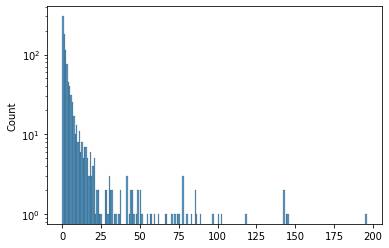

In [65]:

sns.histplot(samples)
plt.semilogy()

In [118]:
from numba import float64, jit
from numba.experimental import jitclass
import numpy as np
from hyperion.constants import Constants

import sys
sys.path.append("/app/gnn_testbed/")
from gnn_testbed.event_generation.photon_propagation import PhotonSource
from gnn_testbed.event_generation.detector import Detector, Module, make_line

exp_exp_exp_sampler = jit(sample_exp_exp_exp)

@jit(nopython=True)
def sample_times(pdf_params, sources, module_coords, module_efficiencies):

    all_times_det = []
    for idom in range(module_coords.shape[0]):

        this_times = []
        total_length = 0
        for isource in range(len(sources)):
            pars = pdf_params[isource, idom]
            usf = 1-10**(-pars[5])
            surv_ratio = 10**pars[6] / 300E7
            n_ph_tot = np.random.poisson(
                surv_ratio * sources[isource].amp * module_efficiencies[idom]
            )

            n_direct, n_indirect = np.random.multinomial(
                n_ph_tot, [usf, 1 - usf]
            )


            all_samples = np.empty(n_ph_tot)

            """
            Can't use this with numba yet
            expon_samples = sampler(*pars[:-2], size=n_indirect, rstate=rstate) + 2
            """
            expon_samples = exp_exp_exp_sampler(pars[0], pars[1], pars[2], pars[3], pars[4], n_indirect) + 2
            uni_samples = np.random.uniform(0, 2, size=n_direct)

            all_samples[:n_direct] = uni_samples
            all_samples[n_direct:] = expon_samples

            this_times.append(all_samples)
            total_length += n_ph_tot

        this_times_arr = np.empty(total_length)
        i = 0
        for tt in this_times:
            this_times_arr[i : i + tt.shape[0]] = tt  # noqa: E203
            i += tt.shape[0]

        all_times_det.append(this_times_arr)

    return all_times_det


def make_generate_photons_nn(model_path):
    import torch

    model = torch.load(model_path)
    model.eval()

    def generate_photons_nn(
        module_coords,
        module_efficiencies,
        sources,
        seed=31337,
    ):

        all_times_det = []
        np.random.seed(seed)

        source_pos = np.empty((len(sources), 3))
        source_amp = np.empty(len(sources))
        source_dir = np.empty((len(sources), 3))

        for i in range(len(sources)):
            source_pos[i] = sources[i].pos
            source_amp[i] = sources[i].amp
            source_dir[i] = sources[i].dir

        source_targ_vec = module_coords[np.newaxis, ...] - source_pos[:, np.newaxis, :]
        dist = np.linalg.norm(source_targ_vec, axis=-1)
        angles = np.arccos(
            np.einsum(
                "abk, ak -> ab",
                source_targ_vec,
                source_dir
            )
            / dist
        )
       
        inp_pars = torch.stack([torch.tensor(angles.ravel(), dtype=torch.float), torch.tensor(np.log10(dist.ravel()), dtype=torch.float)], dim=-1)
        
        pdf_params = (
            model(inp_pars).detach()
            .numpy()
        ).reshape([angles.shape[0], angles.shape[1], 7])

        
        all_times_det = sample_times(
            pdf_params, sources, module_coords, module_efficiencies
        )

        return all_times_det

    return generate_photons_nn

In [119]:
modules = make_line(0, 0, 20, 50, np.random.RandomState(0), 1E-6, 0)

In [120]:

det = Detector(modules)
gen_ph = make_generate_photons_nn("data/arival_time_pars_net.dat")

src = PhotonSource(np.asarray([10., 0., 0]), 10E3*5.3 * 250 * 1e2, 0, np.asarray([0, 0, 1.]))
src2 = PhotonSource(np.asarray([15., 0., 0]), 10E3*5.3 * 250 * 1e2, 0, np.asarray([0, 0, 1.]))
all_times_det = gen_ph(det.module_coords, det.module_efficiencies, [src, src2])

/opt/conda/lib/python3.7/site-packages/numba/core/ir_utils.py:2139: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'sources' of function 'sample_times'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../tmp/ipykernel_91/2319152228.py", line 13:
<source missing, REPL/exec in use?>

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


In [121]:
all_times_det

[array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([], dtype=float64),
 array([  1.72380042, 141.50025887,   1.29104043,   0.36878554]),
 array([3.13884299e-01, 1.35968180e+00, 6.74534994e-01, 9.76057960e-01,
        1.54222890e+00, 7.85311569e-01, 6.79684673e-01, 6.68812242e-01,
        1.87318437e+00, 2.95677781e-01, 1.55290379e+00, 1.35452496e+00,
        7.70115407e-01, 4.96838897e-01, 1.37180543e+00, 1.13394289e+00,
        1.06350545e+00, 9.63462344e-01, 1.73535635e-01, 1.17561608e+00,
        1.20380374e+00, 5.67103861e-01, 5.10225176e-01, 1.12372445e+00,
        1.80849402e+00, 2.81536094e-01, 5.18129413e-01, 1.11615347e+00,
        7.85028423e-01, 9.04045054e-01, 1.42081003e+00, 9.06174799e-01,
        1.07200976e+00, 7.62092495e-01, 1.78360143e+00, 1.43844211e+00,
        1.66746376e+00, 8.09866187e-01, 1.98947728e+00, 1.83612450e+00

[]

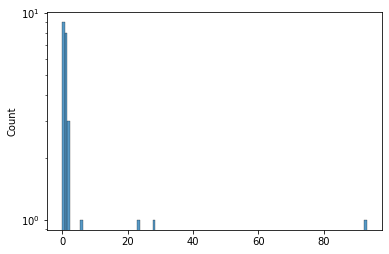

In [5]:
sample_times(a, b, c, d)

/opt/conda/lib/python3.7/site-packages/numba/core/ir_utils.py:2139: NumbaPendingDeprecationWarning: 
Encountered the use of a type that is scheduled for deprecation: type 'reflected list' found for argument 'sources' of function 'sample_times'.

For more information visit https://numba.pydata.org/numba-doc/latest/reference/deprecation.html#deprecation-of-reflection-for-list-and-set-types

File "../../tmp/ipykernel_3580692/1926473208.py", line 13:
<source missing, REPL/exec in use?>

  warnings.warn(NumbaPendingDeprecationWarning(msg, loc=loc))


[array([], dtype=float64)]

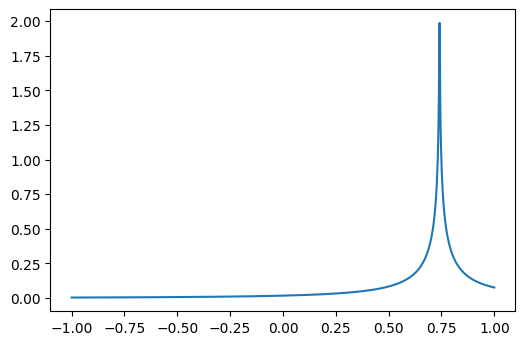

In [2]:
ct = jnp.linspace(-1, 1, 1000)
plt.plot(ct, cherenkov_ang_dist(ct))
a = 4.27033
d = -0.00103
maxval = a - d

In [3]:
fp = np.memmap("photons.dat", dtype="float32", mode="r", shape=(int(1e7), 15, 4))
fpd = np.memmap("photon_dirs.dat", dtype="float32", mode="r", shape=(int(1e7), 3))

In [4]:
theta = np.arccos(1/1.35)
costheta = np.cos(theta)
r = 10

target_x = sph_to_cart(theta, r)
target_r = 0.3

all_t = []
all_w = []

key = random.PRNGKey(0)

nph = int(1E6)
for i in range(10):
    key, subkey = random.split(key)
    isec_times, isec, weights = calc_intersections(fp[nph*i:(i+1)*nph, :, :3], fp[nph*i:(i+1)*nph, :, 3], target_x, target_r, 30, 100 / 90)
    tph = jnp.arccos(fpd[nph*i:(i+1)*nph, 2][jnp.any(isec, axis=1)])
    c_weight = cherenkov_ang_dist(jnp.cos(tph-theta)) / maxval
    all_t.append(isec_times)
    all_w.append(weights*c_weight)
all_t = np.concatenate(all_t)
all_w = np.concatenate(all_w)

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:385: UserWarning: `bins` cannot be 'auto' when using weights. Setting `bins=10`, but you will likely want to adjust.
  warnings.warn(msg, UserWarning)


[]

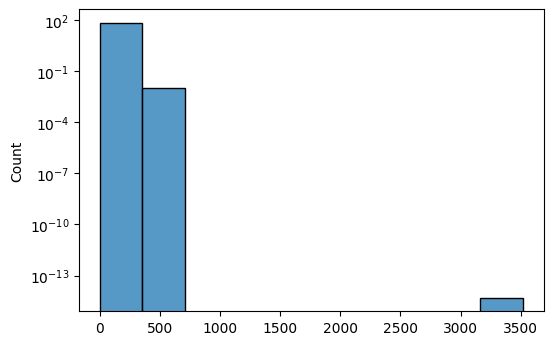

In [5]:
sns.histplot(x=all_t, weights=all_w)
plt.semilogy()

(10, 15)


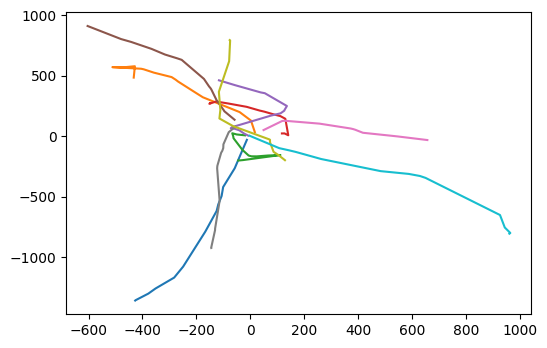

In [55]:
c_medium = 0.3 / 1.35
abs_len = 30
cnt= 10
weights = c_medium * jnp.cumsum(fp[:cnt, :, 3], axis=1) / abs_len 
print(weights.shape)
tph = jnp.arccos(fpd[:cnt, 2])[:, np.newaxis]
weights += jnp.log(cherenkov_ang_dist(jnp.cos(tph-theta)) / maxval)
plt.plot(fp[:cnt, :, 0].T, fp[:cnt, :, 1].T, )#color="k", alpha=0.3);
#plt.scatter(fp[:cnt, :, 0].T, fp[:cnt, :, 1].T, s=10, c=weights)

In [41]:
weights

DeviceArray([[1.56359270e-03, 8.22196063e-03, 2.00255346e-02, ...,
              4.41593230e-01, 5.06838322e-01, 5.72282612e-01],
             [7.41667524e-02, 4.49892193e-01, 9.93589997e-01, ...,
              9.73245049e+00, 1.09010391e+01, 1.21415501e+01],
             [3.92781764e-01, 1.52259445e+00, 2.67169333e+00, ...,
              5.65068169e+01, 6.61603012e+01, 7.60157776e+01],
             ...,
             [3.52552459e-02, 2.08424270e-01, 5.51545143e-01, ...,
              1.09529743e+01, 1.29722805e+01, 1.49930649e+01],
             [1.21581249e-01, 2.84927815e-01, 4.49799180e-01, ...,
              3.47459435e+00, 3.89629364e+00, 4.31951427e+00],
             [8.24529156e-02, 1.89396158e-01, 6.21439517e-01, ...,
              9.45266533e+00, 1.06455526e+01, 1.19224834e+01]],            dtype=float32)

In [94]:
a = np.ones((2, 3))
b = np.ones((5, 3))*2

np.linalg.norm((a[:, np.newaxis, : ] - b[np.newaxis, ...]), axis=(-1)).shape

(2, 5)

In [95]:
np.einsum('abk, ijk -> aj', a[:, np.newaxis, : ], b[np.newaxis, ...])

array([[6., 6., 6., 6., 6.],
       [6., 6., 6., 6., 6.]])

In [83]:
for i in range(a.shape[0]):
    for j in range(b.shape[1]):
        print(np.dot(a[i, j]
    

array([[1., 1., 1.],
       [1., 1., 1.]])

In [84]:
b

array([[2., 2., 2.],
       [2., 2., 2.]])

In [85]:
1 *2 + 1*2 + 1*2

6